# VAE

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [4]:
dataset = torchvision.datasets.MNIST(root='../data/minist',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

In [5]:
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 15
batch_size = 128
learning_rate = 1e-3

In [6]:
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [7]:
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        # nn.Linear(in_features, out_features, bias)
        # in_features: 输入的神经元个数
        # out_features: 输出的神经元个数
        # bias: Boolean value，是否包含 bias
        # Y^(n*o) = X^(n*i)W^(i*o) + b
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim) # 均值 向量
        self.fc3 = nn.Linear(h_dim, z_dim) # 标准方差 向量
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)

    # 编码过程
    def encode(self, x):
        # h^(400)
        # 每个数字图片中 784 维向量，变为 400 维向量
        h = F.relu(self.fc1(x))
        # fc2^(20), fc3^(20)
        # 每个 h 400 维向量，变为 20 维向量
        return self.fc2(h), self.fc3(h)

    # 随机生成隐含向量
    def reparameterize(self, mu, log_var):
        # e^(ln(var)/2) = var^(0.5)
        std = torch.exp(log_var/2)
        # 和 std 大小相同的，均值为 0，方差为 1 的 eps
        eps = torch.randn_like(std)
        # 返还 z = 均值 + eps * 方差
        return mu + eps * std

    # 解码过程
    def decode(self, z):
        # h^(400)
        # 将每个 z 20 维向量，变为 400 为向量
        h = F.relu(self.fc4(z))
        # fc5^(784)
        # 将每个 h 400 维向量，变为 784 为向量
        return F.sigmoid(self.fc5(h))

    # 整个前向传播过程：编码-》解码
    def forward(self, x):
        # 20 维的均值和方差
        mu, log_var = self.encode(x)
        # 均值和方差中采样出 z 20维
        z = self.reparameterize(mu, log_var)
        # 使用 z 重构出 x 784 维
        x_reconst = self.decode(z)
        # 返还重构的 x，均值，方差
        return x_reconst, mu, log_var

In [8]:
model = VAE().to(device)

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # 获取样本，并前向传播
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)

        # 计算重构损失和KL散度（KL散度用于衡量两种分布的相似程度）
        # KL散度的计算可以参考论文或者文章开头的链接
        # 重构损失
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        # 预设 z 的分布和 encoder 得到的分布的差距
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # 反向传播和优化
        # 总损失
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))

    # 利用训练的模型进行测试
    with torch.no_grad():
        # 随机生成的图像
        z = torch.randn(batch_size, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)
        save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

        # 重构的图像
        out, _, _ = model(x)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))

D:\Environment\Anaconda\d2l\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
D:\Environment\Anaconda\d2l\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/15], Step [100/469], Reconst Loss: 21772.6445, KL Div: 1356.8738
Epoch[1/15], Step [200/469], Reconst Loss: 17639.1387, KL Div: 2096.0657
Epoch[1/15], Step [300/469], Reconst Loss: 15295.8223, KL Div: 2369.7876
Epoch[1/15], Step [400/469], Reconst Loss: 14811.6465, KL Div: 2429.9448
Epoch[2/15], Step [100/469], Reconst Loss: 13600.2490, KL Div: 2618.9189
Epoch[2/15], Step [200/469], Reconst Loss: 12710.9404, KL Div: 2779.0479
Epoch[2/15], Step [300/469], Reconst Loss: 11903.0146, KL Div: 3060.1396
Epoch[2/15], Step [400/469], Reconst Loss: 12662.3584, KL Div: 3007.9326
Epoch[3/15], Step [100/469], Reconst Loss: 11861.7900, KL Div: 2967.3525
Epoch[3/15], Step [200/469], Reconst Loss: 11823.6543, KL Div: 3176.8086
Epoch[3/15], Step [300/469], Reconst Loss: 11488.6641, KL Div: 3016.2886
Epoch[3/15], Step [400/469], Reconst Loss: 10843.2979, KL Div: 2999.7236
Epoch[4/15], Step [100/469], Reconst Loss: 11219.6055, KL Div: 3154.5178
Epoch[4/15], Step [200/469], Reconst Loss: 11643.18

# Show Results

In [11]:
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np

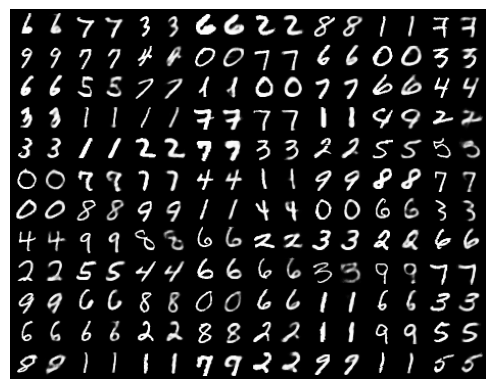

In [12]:
reconsPath = './samples/reconst-15.png'
Image = mpimg.imread(reconsPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

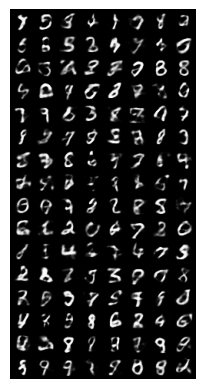

In [13]:
genPath = './samples/sampled-15.png'
Image = mpimg.imread(genPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

In [14]:
model_test = VAE().to(device)
optimizer_test = torch.optim.Adam(model_test.parameters(), lr=learning_rate)

In [57]:
num_epochs = 1
for epoch in range(num_epochs):
    # count = 0
    for i, (x, y) in enumerate(data_loader):
        x = x.to(device).view(-1, image_size)
        print(i)
        print(x)
        print(x.shape)
        print(y)
        print(y.shape)
        # count += 1
        print(y[y==6])
        print(y[y==8])
        print(torch.cat((y[y==6], y[y==8])))
        break

# count = 469
# 469 个 batch

0
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
torch.Size([128, 784])
tensor([4, 1, 3, 0, 4, 2, 7, 2, 4, 4, 2, 8, 2, 8, 1, 2, 1, 8, 6, 1, 0, 6, 3, 6,
        2, 5, 9, 5, 5, 3, 4, 3, 1, 0, 9, 0, 8, 7, 1, 4, 9, 9, 9, 6, 3, 3, 8, 9,
        4, 6, 7, 4, 9, 5, 1, 3, 9, 6, 5, 0, 7, 5, 5, 4, 0, 2, 1, 4, 4, 7, 0, 8,
        0, 1, 6, 2, 3, 5, 5, 0, 1, 1, 4, 2, 7, 3, 6, 5, 6, 0, 8, 1, 8, 6, 2, 3,
        8, 4, 8, 5, 5, 1, 1, 5, 2, 5, 2, 3, 3, 4, 1, 5, 7, 5, 5, 8, 1, 2, 8, 3,
        2, 2, 7, 3, 2, 3, 4, 2])
torch.Size([128])
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6])
tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])


In [ ]:
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # 获取样本，并前向传播
        # x 为 data [128 * 784]
        # 128 个数字
        # 每个数字为一个 784 个数的向量
        # y 为 label [128] 的向量
        x = x.to(device).view(-1, image_size)
        # 将 x 输入到 VAE 中，得到重构的 x，mu 和 log_var
        x_reconst, mu, log_var = model_test(x)

        # 计算重构损失和KL散度（KL散度用于衡量两种分布的相似程度）
        # KL散度的计算可以参考论文或者文章开头的链接
        # 重构损失
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        # 预设 z 的分布和 encoder 得到的分布的差距（高斯分布）
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # 反向传播和优化
        # 总损失
        loss = reconst_loss + kl_div
        optimizer_test.zero_grad()
        loss.backward()
        optimizer_test.step()

        if (i+1) % 100 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))

    # 利用训练的模型进行测试
    with torch.no_grad():
        # 随机生成的图像
        z = torch.randn(batch_size, z_dim).to(device)
        out = model_test.decode(z).view(-1, 1, 28, 28)
        save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

        # 重构的图像
        out, _, _ = model_test(x)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))

# SIX

In [58]:
model_test = VAE().to(device)
optimizer_test = torch.optim.Adam(model_test.parameters(), lr=learning_rate)

In [59]:
num_epochs = 15
for epoch in range(num_epochs):
    for i, (x, y) in enumerate(data_loader):
        x = x.to(device).view(-1, image_size)
        x = torch.cat((x[y==6], x[y==8]))

        x_reconst, mu, log_var = model_test(x)
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        loss = reconst_loss + kl_div
        optimizer_test.zero_grad()
        loss.backward()
        optimizer_test.step()

        if (i+1) % 100 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))

    with torch.no_grad():
        # 随机生成的图像
        z = torch.randn(batch_size, z_dim).to(device)
        out = model_test.decode(z).view(-1, 1, 28, 28)
        save_image(out, os.path.join(sample_dir, 'six/sampled-{}.png'.format(epoch+1)))

        # 重构的图像
        out, _, _ = model_test(x)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, os.path.join(sample_dir, 'six/reconst-{}.png'.format(epoch+1)))

D:\Environment\Anaconda\d2l\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
D:\Environment\Anaconda\d2l\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/15], Step [100/469], Reconst Loss: 3634.3345, KL Div: 252.9902
Epoch[1/15], Step [200/469], Reconst Loss: 2402.4067, KL Div: 230.0822
Epoch[1/15], Step [300/469], Reconst Loss: 3848.9697, KL Div: 313.1414
Epoch[1/15], Step [400/469], Reconst Loss: 4142.3467, KL Div: 430.4464
Epoch[2/15], Step [100/469], Reconst Loss: 3095.1150, KL Div: 390.6050
Epoch[2/15], Step [200/469], Reconst Loss: 1652.4182, KL Div: 275.0906
Epoch[2/15], Step [300/469], Reconst Loss: 3682.5234, KL Div: 563.2695
Epoch[2/15], Step [400/469], Reconst Loss: 2825.7410, KL Div: 505.3782
Epoch[3/15], Step [100/469], Reconst Loss: 2906.7249, KL Div: 568.9774
Epoch[3/15], Step [200/469], Reconst Loss: 2879.3677, KL Div: 538.1617
Epoch[3/15], Step [300/469], Reconst Loss: 2531.0586, KL Div: 446.8206
Epoch[3/15], Step [400/469], Reconst Loss: 2368.9456, KL Div: 500.4715
Epoch[4/15], Step [100/469], Reconst Loss: 2888.5183, KL Div: 618.1987
Epoch[4/15], Step [200/469], Reconst Loss: 2138.4182, KL Div: 472.8515
Epoch[